# LMS on a real-weighted graph

In [18]:
# If gspx is not installed, we add it to the path
import os, sys
gdir = os.path.dirname(os.getcwd())  # parent folder
sys.path.insert(0, gdir)

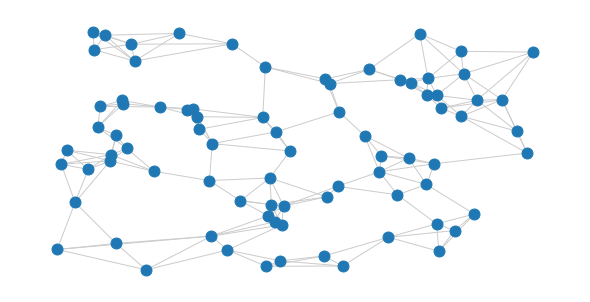

In [29]:
import numpy as np
from gspx.utils.graph import make_sensor
from gspx.utils.display import plot_graph
from gspx.utils.graph import graph_total_variation
from gspx.adaptive import LMS

A, coords = make_sensor(N=80)
plot_graph(
    A, coords=coords,
    figsize=(8, 4), colormap='viridis',
    node_size=120)

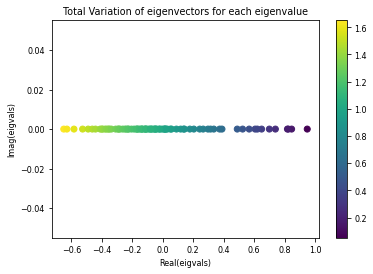

In [23]:
import matplotlib.pyplot as plt

eigvals, V = np.linalg.eig(A)
tv = graph_total_variation(V, A)

plt.scatter(np.real(eigvals), np.imag(eigvals), c=tv)
plt.colorbar()
plt.title("Total Variation of eigenvectors for each eigenvalue")
plt.xlabel("Real(eigvals)")
plt.ylabel("Imag(eigvals)")
plt.show()

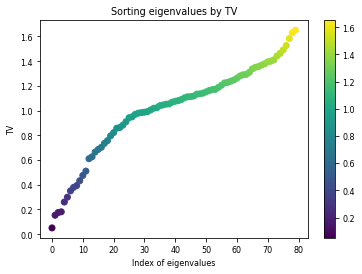

In [24]:
idx_freq = np.argsort(tv)

plt.figure()
plt.scatter(np.arange(len(idx_freq)), tv[idx_freq], c=tv[idx_freq])
plt.xlabel("Index of eigenvalues")
plt.ylabel("TV")
plt.title("Sorting eigenvalues by TV")
plt.colorbar()
plt.show()

### Ideal filter response

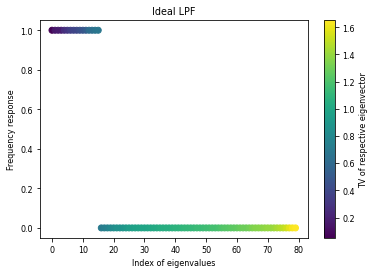

In [25]:
h_ideal = np.zeros(len(idx_freq))

# Bandwith of 20% the frequency support
bandwidth = int(len(idx_freq) / 5)
h_ideal[idx_freq[:bandwidth]] = 1

plt.figure()
plt.scatter(np.arange(len(idx_freq)), h_ideal[idx_freq], c=tv[idx_freq])
plt.xlabel("Index of eigenvalues")
plt.ylabel("Frequency response")
cbar = plt.colorbar()
cbar.set_label("TV of respective eigenvector", rotation=90)
plt.title("Ideal LPF")
plt.show()

In [26]:
# Heat kernel
k = 0.2
ss = np.exp(-k * np.arange(len(idx_freq)))

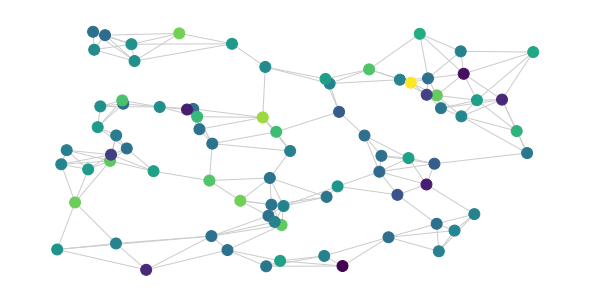

In [27]:
from gspx.utils.gsp import gft, igft

s = igft(A, ss)

plot_graph(
    A, coords=coords, colors=s,
    figsize=(8, 4), colormap='viridis',
    node_size=120)

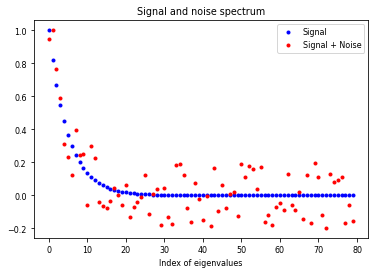

In [28]:
rnd = np.random.RandomState(seed=42)
err_amplitude = 0.2
nn = rnd.uniform(low=-err_amplitude, high=err_amplitude, size=len(ss))

sn = igft(A, ss + nn)

plt.figure()
plt.plot(np.arange(len(idx_freq)), ss, 'b.', label="Signal")
plt.plot(np.arange(len(idx_freq)), ss + nn, 'r.', label="Signal + Noise")
plt.xlabel("Index of eigenvalues")
plt.title("Signal and noise spectrum")
plt.legend(loc="upper right")
plt.show()

In [30]:
MAX_ITR = 1000
deg = 7

eig_vander = np.vander(eigvals, N=deg, increasing=True)
theta_ideal = h_ideal[:, np.newaxis]
print(eig_vander.shape, theta_ideal.shape)

learning_rates = [0.001, 0.01, 0.1, 0.3]

lms = LMS(max_iter=MAX_ITR, alpha=learning_rates, scale=True)
lms.fit(eig_vander, y=theta_ideal)

(80, 7) (80, 1)


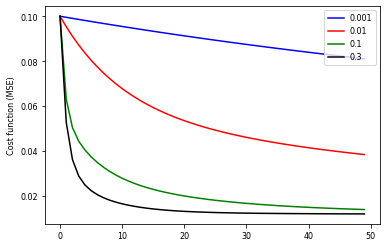

In [32]:
import matplotlib.pyplot as plt

plotstyle = ['b', 'r', 'g', 'k', 'b--', 'r--']

plt.figure()
for i, val in enumerate(lms.res_.keys()):
    plt.plot(
        np.arange(MAX_ITR)[:50],
        lms.res_[val]['cost'][:50],
        plotstyle[i],
        label=val)
plt.ylabel("Cost function (MSE)")
plt.legend(loc="upper right")

plt.show()

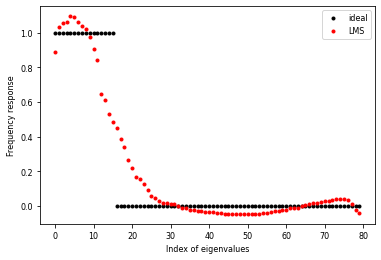

In [33]:
h_opt = lms.predict(eig_vander)

plt.figure()
plt.plot(np.arange(len(idx_freq)), h_ideal[idx_freq], 'k.', label="ideal")
plt.plot(np.arange(len(idx_freq)), h_opt[idx_freq], 'r.', label="LMS")
plt.xlabel("Index of eigenvalues")
plt.ylabel("Frequency response")
plt.legend(loc="upper right")
plt.show()

### Removing noise with the adaptive filter

In [34]:
print("MSE prior:", np.mean((s - sn)**2))

MSE prior: 0.014951009268568901


In [35]:
s_lpf = igft(A, (ss + nn) * h_opt.ravel())

print("MSE post:", np.mean((s - s_lpf)**2))

MSE post: 0.003314397722170622


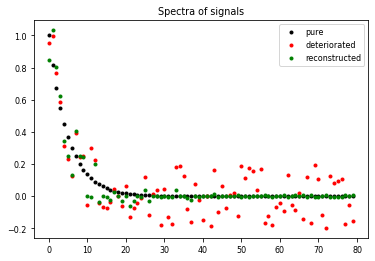

In [36]:
plt.figure()
plt.plot(np.arange(len(idx_freq)), np.abs(ss), 'k.', label="pure")
plt.plot(np.arange(len(idx_freq)), (ss + nn), 'r.', label="deteriorated")
plt.plot(np.arange(len(idx_freq)), (ss + nn) * h_opt.ravel(), 'g.', label="reconstructed")
plt.legend(loc="upper right")
plt.title("Spectra of signals")
plt.show()